In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

#### According to Convolution Theorem if we want to convolve a filter `h` with an image `f` that is equivalent to the Fourier transform of the filter multiplied point-by-point by Fourier transform of original image. To go back to the spatial domain we take the inverse Fourier of H x F product.

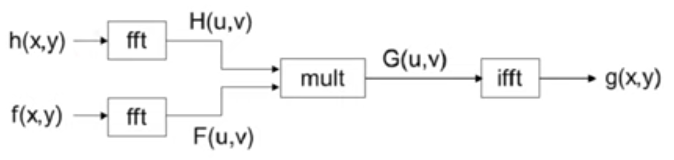

In [2]:
from IPython.display import Image
Image(filename="../assets/filtering_in_freq.png") 

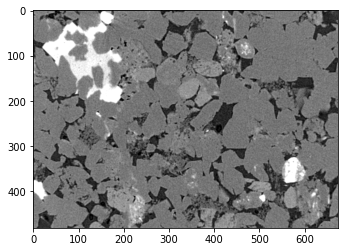

In [3]:
f = cv2.imread("../assets/sandstone.tif", 0)
plt.imshow(f, cmap="gray")

In [4]:
#Get the FFT of the image
F = cv2.dft(np.float32(f), flags=cv2.DFT_COMPLEX_OUTPUT)

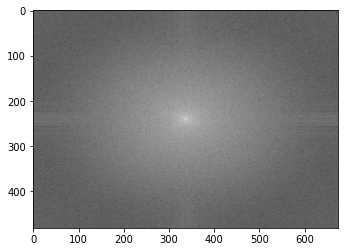

In [5]:
#Shift low frequency to the center
F_shift = np.fft.fftshift(F)
#To visualize returned magnitude spectrum we use log
#dft_shift[:,:,0] - real number, dft_shift[:,:,1] - imaginary number
magnitude_spectrum = 2 * np.log((cv2.magnitude(F_shift[:,:,0], F_shift[:,:,1])))
plt.imshow(magnitude_spectrum.astype(np.int8), cmap="gray")

In [6]:
#Box filter 20x20
N = 20
SUM = N*N
h = np.ones((N,N),np.float32)/SUM
h.shape

(20, 20)

In [7]:
F.shape

(481, 674, 2)

(481, 674)


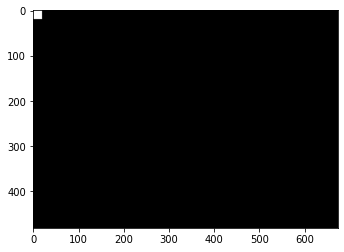

In [8]:
#We need to make the filter same size as out input image with padding 0
pad_top = 0
pad_bottom = F.shape[0] - N
pad_left = 0
pad_right = F.shape[1] - N

h_padded = np.pad(h, ((pad_top, pad_bottom), (pad_left, pad_right)), 'constant')
print(h_padded.shape)
plt.imshow(h_padded, cmap="gray")

In [9]:
#Get FFT of the filter h
H = cv2.dft(np.float32(h_padded), flags = cv2.DFT_COMPLEX_OUTPUT)

/tmp/ipykernel_12940/1521914915.py:5: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 10 * np.log((cv2.magnitude(H_shift[:,:,0], H_shift[:,:,1])))


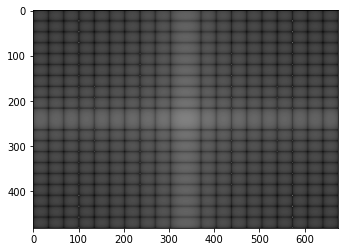

In [10]:
#Shift low frequency to the center
H_shift = np.fft.fftshift(H)
#To visualize returned magnitude spectrum we use log
#dft_shift[:,:,0] - real number, dft_shift[:,:,1] - imaginary number
magnitude_spectrum = 10 * np.log((cv2.magnitude(H_shift[:,:,0], H_shift[:,:,1])))
plt.imshow(magnitude_spectrum.astype(np.int8), cmap="gray")

In [11]:
#G - get point-by-point multiplication
G = F * H

In [12]:
#Get the inverse of G
g = cv2.idft(G)
g = g[:, :, 0] #0 represents only real part, we drop the imaginary part

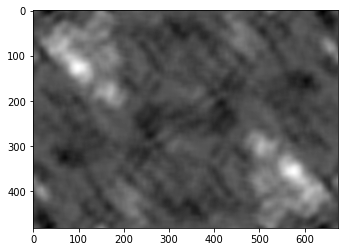

In [13]:
plt.imshow(g, cmap="gray")

### Original image f convolved with filter h

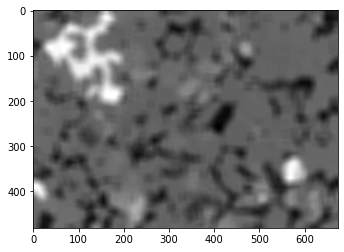

In [14]:
dst = cv2.filter2D(f,-1,h)
plt.imshow(dst, cmap="gray")

### `Notch Filter` to remove periodic noise by manually masking frequencies

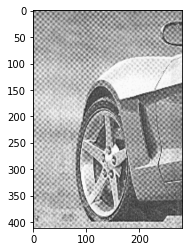

In [15]:
f = cv2.imread("../assets/newspaper_car_moire_pattern.png", 0)
plt.imshow(f, cmap="gray")

In [16]:
#Get the Fourier tranformed image
F = cv2.dft(np.float32(f), flags=cv2.DFT_COMPLEX_OUTPUT)

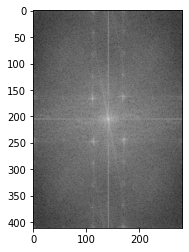

In [17]:
#Shift low frequency to the center
F_shift = np.fft.fftshift(F)
#To visualize returned magnitude spectrum we use log
#dft_shift[:,:,0] - real number, dft_shift[:,:,1] - imaginary number
magnitude_spectrum = 2 * np.log((cv2.magnitude(F_shift[:,:,0], F_shift[:,:,1])))
plt.imshow(magnitude_spectrum.astype(np.int8), cmap="gray")

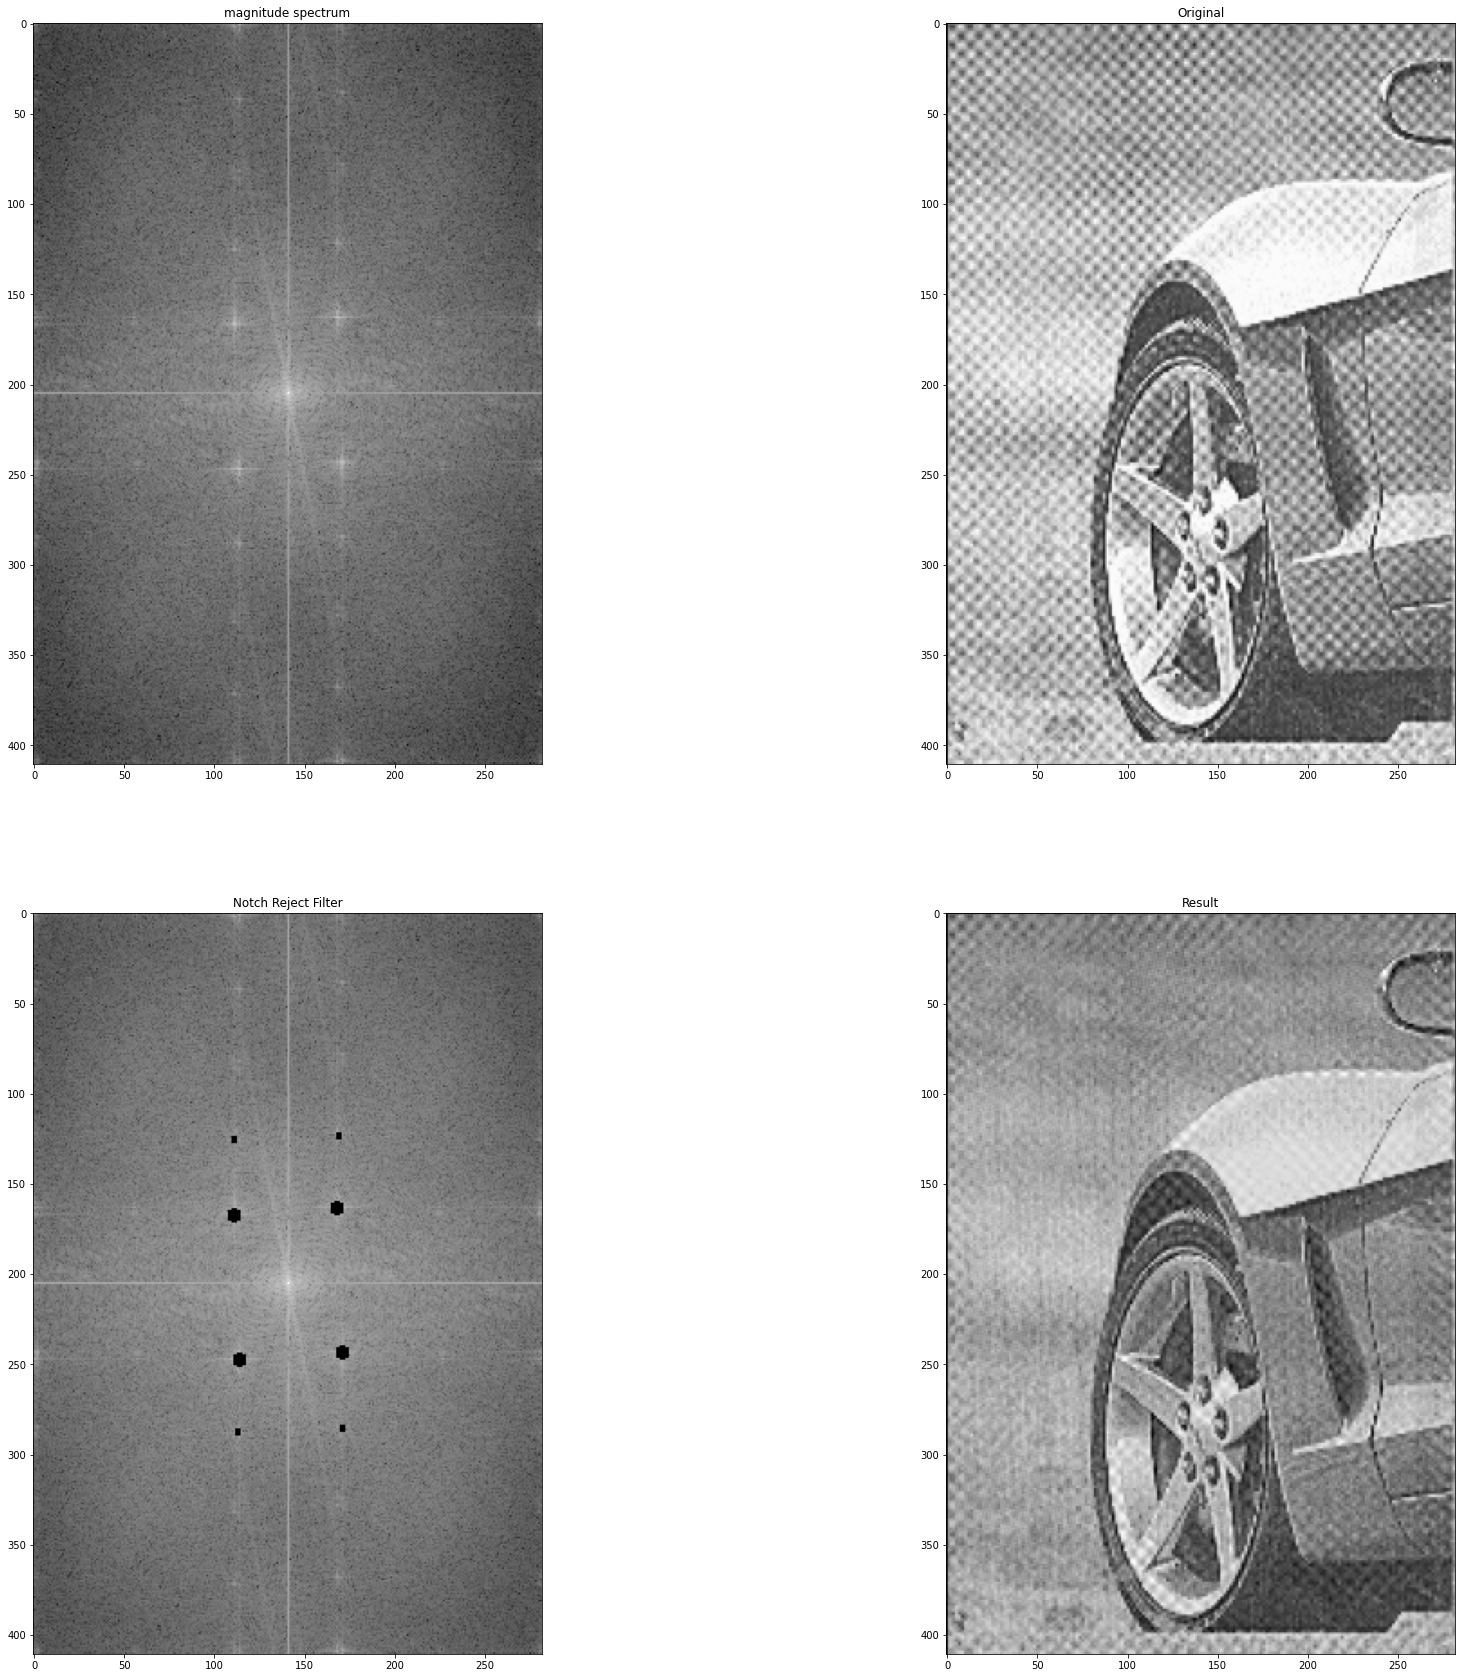

In [18]:
plt.rcParams["figure.figsize"] = (30,30)
def notch_reject_filter(shape, d0=9, u_k=0, v_k=0):
    P, Q = shape
    # Initialize filter with zeros
    H = np.zeros((P, Q))

    # Traverse through filter
    for u in range(0, P):
        for v in range(0, Q):
            # Get euclidean distance from point D(u,v) to the center
            D_uv = np.sqrt((u - P / 2 + u_k) ** 2 + (v - Q / 2 + v_k) ** 2)
            D_muv = np.sqrt((u - P / 2 - u_k) ** 2 + (v - Q / 2 - v_k) ** 2)

            if D_uv <= d0 or D_muv <= d0:
                H[u, v] = 0.0
            else:
                H[u, v] = 1.0

    return H

img = cv2.imread('../assets/newspaper_car_moire_pattern.png', 0)

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
phase_spectrumR = np.angle(fshift)
magnitude_spectrum = 20*np.log(np.abs(fshift))

img_shape = img.shape

H1 = notch_reject_filter(img_shape, 4, 38, 30)
H2 = notch_reject_filter(img_shape, 4, -42, 27)
H3 = notch_reject_filter(img_shape, 2, 80, 30)
H4 = notch_reject_filter(img_shape, 2, -82, 28)

NotchFilter = H1*H2*H3*H4
NotchRejectCenter = fshift * NotchFilter 
NotchReject = np.fft.ifftshift(NotchRejectCenter)
inverse_NotchReject = np.fft.ifft2(NotchReject)  # Compute the inverse DFT of the result


Result = np.abs(inverse_NotchReject)

plt.subplot(222)
plt.imshow(img, cmap='gray')
plt.title('Original')

plt.subplot(221)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('magnitude spectrum')

plt.subplot(223)
plt.imshow(magnitude_spectrum*NotchFilter, "gray") 
plt.title("Notch Reject Filter")

plt.subplot(224)
plt.imshow(Result, "gray") 
plt.title("Result")


plt.show()


### Phase Correlation - applied to find the shift between two images

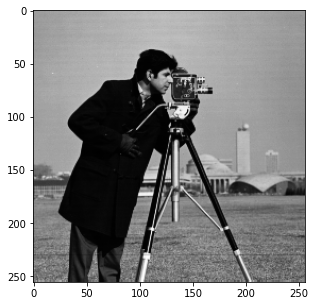

In [26]:
plt.rcParams["figure.figsize"] = (5,5)
img_1 = cv2.imread("../assets/cameraman.png", 0)
plt.imshow(img_1, cmap="gray")

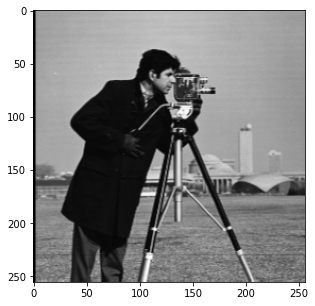

In [28]:
#Shift the image in X direction by 2.5 pixels
rows,cols = img_1.shape
x = 2.5
M = np.float32([[1,0,x],
                [0,1,0]])
img_2 = cv2.warpAffine(img_1, M, (cols,rows))
plt.imshow(img_2, cmap="gray")

In [31]:
def show_spectrum(dft, cmap="gray"):
    magnitude_spectrum = 2 * np.log(np.abs(dft))
    magnitude_spectrum = np.int8(magnitude_spectrum)

    plt.imshow(magnitude_spectrum, cmap="gray")

def fourier_transform(image):
    F = np.fft.fft2(image)
    #Shift low frequency to the center
    F_shift = np.fft.fftshift(F)
    #To visualize returned magnitude spectrum we use log
    #dft_shift[:,:,0] - real number, dft_shift[:,:,1] - imaginary number
    show_spectrum(F_shift)
    return F

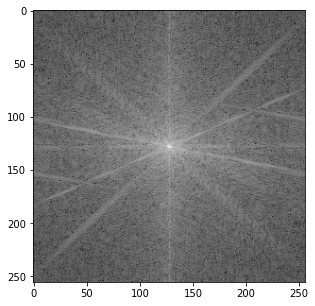

In [32]:
#Get Fourier transform of image 1
F1 = fourier_transform(img_1)

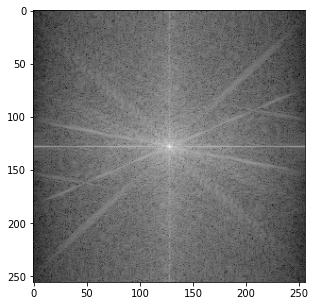

In [33]:
#Get Fourier transform of image 2
F2 = fourier_transform(img_2)

In [40]:
#Get the ration of F2 to F1
F3 = np.divide(F2, F1)

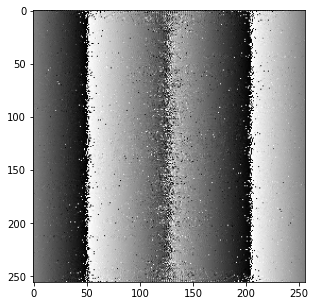

In [41]:
#Find angle at every point and show 
phase_angle = np.angle(F3)
plt.imshow(phase_angle, cmap="gray")

##### Above is the angle in radians at every point. We want to find the slope in a horizontal direction because we shifted the image in X direction only.

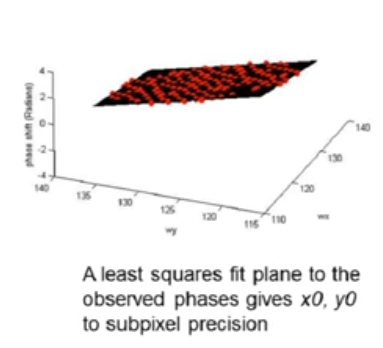

In [42]:
Image(filename="../assets/u_v_phase_plane.png")

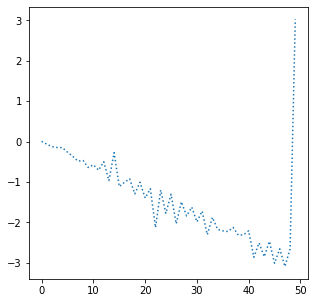

In [47]:
#In X direction show the change in angle for first 50 columns
plt.plot(phase_angle[1,:50], linestyle = 'dotted')
plt.show()

From the above plot we can see for the first 50 columns in the phase angle image, we have a negative slope. Change in `y` direction in the plot is -3 and `x` direction is 50. By `rise over run` the 
* `slope = -3 / 50`

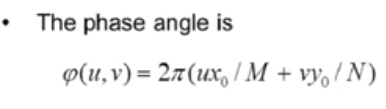

In [48]:
Image(filename="../assets/phase_angle.png")

We dont have shift in y direction, so the slope is
* `slope = 2*pi*x0 / M`<br>
If we solve for `x0` then
* `x0 = slope * M / (2*pi)`

In [54]:
M = 256
slope = -3/50
slope

-0.06

In [55]:
x0 = slope*M / (2*np.pi)
print(f"Shift in x direction between 2 images was: {x0}")

Shift in x direction between 2 images was: -2.4446199258915122


The result is pretty close to the actual shift that we have done to the first image `2.5`